In [1]:
import tensorflow as tf

from tensorflow.keras.layers import Conv2D, MaxPool2D, UpSampling2D, Dense, Add, Conv2DTranspose
from cvnn.layers import ComplexConv2D, ComplexMaxPooling2D, ComplexUpSampling2D, ComplexConv2DTranspose
from cvnn.activations import crelu, zrelu, modrelu
from tensorflow.keras import Sequential
from tensorflow.keras import Input
from tensorflow.keras import Model
from tensorflow.keras import mixed_precision
from tensorflow.keras.models import load_model
from copy import deepcopy
import cvnn

import numpy as np
import glob
from tqdm.notebook import tqdm as tqdm
import os

from keras_helper import *
from skimage.transform import resize

#from keras_helper import *
#from skimage.transform import resize

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
#print(os.environ["CUDA_VISIBLE_DEVICES"])
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
if len(gpus):
  try:
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
      print("Restricting Memory")
  except RuntimeError as e:
    print(e)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
Restricting Memory
Restricting Memory


In [4]:
!nvidia-smi

Thu Aug 19 13:01:25 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.59       Driver Version: 440.59       CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Quadro P4000        Off  | 00000000:03:00.0 Off |                  N/A |
| 46%   30C    P8     5W / 105W |     12MiB /  8119MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Quadro P4000        Off  | 00000000:04:00.0 Off |                  N/A |
| 46%   33C    P8     5W / 105W |    558MiB /  8112MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
        

In [101]:
from  cyclic_lr import *

In [5]:
import matplotlib.pyplot as plt
import matplotlib

# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline


In [6]:
def plot3(data, titles):
    if(len(titles)<3):
        titles=["Plot1", "Plot2", "Plot3"]
    fig,ax = plt.subplots(1,3, figsize=(20,12))
    im=ax[0].imshow(data[0])
    ax[0].set_title(titles[0])
    ax[0].axis('off')
    plt.colorbar(im,ax=ax[0], fraction=0.046, pad=0.04)
    im=ax[1].imshow(data[1])
    ax[1].set_title(titles[1])
    ax[1].axis('off')
    plt.colorbar(im,ax=ax[1], fraction=0.046, pad=0.04)
    im=ax[2].imshow(data[2])
    ax[2].set_title(titles[2])
    ax[2].axis('off')
    plt.colorbar(im,ax=ax[2], fraction=0.046, pad=0.04)

### Some training parameters

In [7]:
path = './'

In [18]:
h,w=64,64
nepochs=60
wt_path = 'weights_cmplx'
batch_size = 32

if (not os.path.isdir(path+wt_path)):
    os.mkdir(wt_path)

### Read experimental diffraction data and reconstructed images

In [9]:
#plt.matshow(np.log10(data_diffr[0,0]))
try:
    data_diffr_red = np.load(path + '../data/20191008_39_diff_reduced.npz')['arr_0']
except:
    data_diffr = np.load(path+'../data/20191008_39_diff.npz')['arr_0']
    data_diffr_red = np.zeros((data_diffr.shape[0],data_diffr.shape[1],64,64), float)
    for i in tqdm(range(data_diffr.shape[0])):
        for j in range(data_diffr.shape[1]):
            data_diffr_red[i,j] = resize(data_diffr[i,j,32:-32,32:-32],(64,64),preserve_range=True, anti_aliasing=True)
            data_diffr_red[i,j] = np.where(data_diffr_red[i,j]<3,0,data_diffr_red[i,j])


In [10]:
real_space = np.load(path+'../data/20191008_39_amp_pha_10nm_full.npy')
amplitudes = np.abs(real_space)
phases = np.angle(real_space)
amplitudes.shape

(161, 161, 64, 64)

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


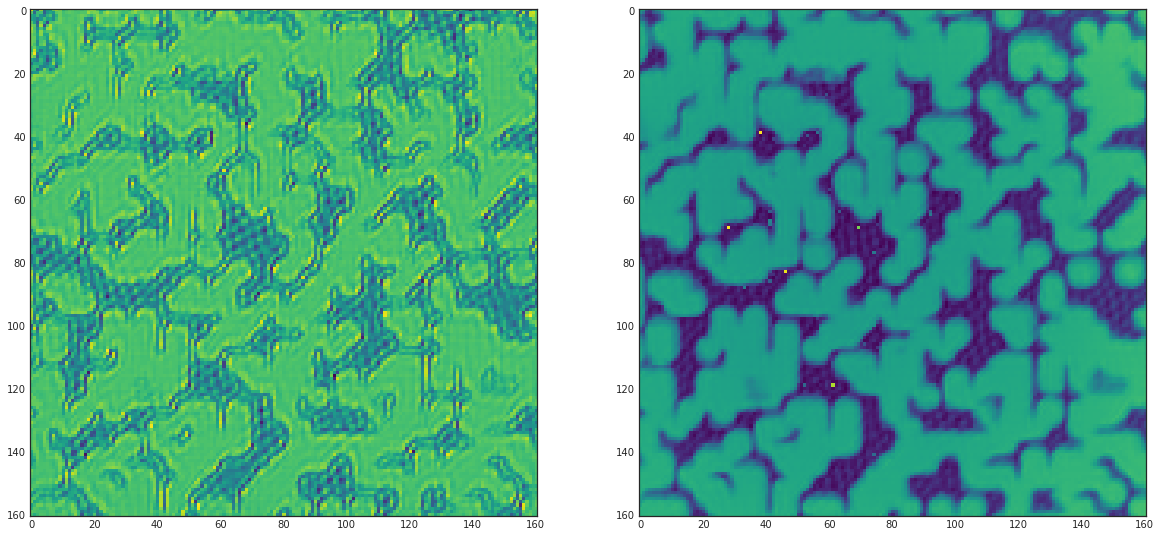

In [11]:
fig,ax = plt.subplots(1,2,figsize=(20,10))
ax[0].imshow(amplitudes[:,:,32,32])
ax[1].imshow(phases[:,:,32,32])

In [15]:
nlines = 100 #How many lines of data to use for training?
nltest = 60 #How many lines for the test set?
tst_strt = amplitudes.shape[0] - nltest #Where to index from
print(tst_strt)



101


In [17]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split


X_train = data_diffr_red[:nlines,:].reshape(-1,h,w)[:,:,:,np.newaxis]
X_test = data_diffr_red[tst_strt:,tst_strt:].reshape(-1,h,w)[:,:,:,np.newaxis]
Y_I_train = amplitudes[:nlines,:].reshape(-1,h,w)[:,:,:,np.newaxis]
Y_I_test = amplitudes[tst_strt:,tst_strt:].reshape(-1,h,w)[:,:,:,np.newaxis]
Y_phi_train = phases[:nlines,:].reshape(-1,h,w)[:,:,:,np.newaxis]
Y_phi_test = phases[tst_strt:,tst_strt:].reshape(-1,h,w)[:,:,:,np.newaxis]

ntrain = X_train.shape[0]*X_train.shape[1]
ntest = X_test.shape[0]*X_test.shape[1]

print(X_train.shape, X_test.shape)

X_train, Y_I_train, Y_phi_train = shuffle(X_train, Y_I_train, Y_phi_train, random_state=0)

X_train = (X_train + 0j).astype('complex64')
Y_train = Y_I_train * np.exp(1j * Y_phi_train)
Y_train = Y_train.astype('complex64')

X_test = (X_test + 0j).astype('complex64')
Y_test = Y_I_test * np.exp(1j * Y_phi_test)
Y_test = Y_test.astype('complex64')

(16100, 64, 64, 1) (3600, 64, 64, 1)


## Define the network structure

In [108]:
tf.keras.backend.clear_session()
np.random.seed(123)

files=glob.glob('%s/*' % wt_path)
for file in files:
    os.remove(file)

#plot_model(autoencoder, to_file='paper_data/str_model.png')


In [109]:
X_train.shape

(16100, 64, 64, 1)

In [110]:
input_img = Input(shape=(h, w, 1), dtype='complex64') 

el1 = ComplexConv2D(32, (3, 3), activation=crelu, padding='same', data_format='channels_last')(input_img)
#el2 = ComplexConv2D(32, (3, 3), activation=crelu, padding='same', data_format='channels_last')(el1)
#el3 = ComplexMaxPooling2D((2, 2), padding='same', data_format='channels_last')(el2)
el3 = ComplexConv2D(32, (3, 3), strides=(2,2), padding='same', data_format='channels_last', activation=crelu)(el1)

In [111]:
el4 = ComplexConv2D(64, (3, 3), activation=crelu, padding='same', data_format='channels_last')(el3)
#el5 = ComplexConv2D(64, (3, 3), activation=crelu, padding='same', data_format='channels_last')(el4)
#el6 = ComplexMaxPooling2D((2, 2), padding='same', data_format='channels_last')(el5)
el6 = ComplexConv2D(64, (3, 3), strides=(2,2), padding='same', data_format='channels_last', activation=crelu)(el4)

el7 = ComplexConv2D(128, (3, 3), activation=crelu, padding='same', data_format='channels_last')(el6)
#el8 = ComplexConv2D(128, (3, 3), activation=crelu, padding='same', data_format='channels_last')(el7)
#el9 = ComplexMaxPooling2D((2, 2), padding='same', data_format='channels_last')(el8)
el9 = ComplexConv2D(128, (3, 3), strides=(2,2), padding='same', data_format='channels_last', activation=crelu)(el6)

encoded = el9



In [112]:
dl1 = ComplexConv2D(128, (3, 3), activation=crelu, padding='same', data_format='channels_last')(encoded)
#dl2 = ComplexConv2D(128, (3, 3), activation=crelu, padding='same', data_format='channels_last')(dl1)
dl3 = ComplexConv2DTranspose(128, (3, 3), strides=(2,2), padding='same', data_format='channels_last', activation=crelu)(dl1)

#dl3 = ComplexUpSampling2D((2, 2), data_format='channels_last', interpolation='nearest')(dl2)

In [113]:
dl4 = ComplexConv2D(64, (3, 3), activation=crelu, padding='same', data_format='channels_last')(dl3)
#dl5 = ComplexConv2D(64, (3, 3), activation=crelu, padding='same', data_format='channels_last')(dl4)
dl6 = ComplexConv2DTranspose(64, (3, 3), strides=(2,2), padding='same', data_format='channels_last', activation=crelu)(dl4)

#dl3 = ComplexUpSampling2D((2, 2), data_format='channels_last', interpolation='nearest')(dl2)

In [114]:
dl7 = ComplexConv2D(32, (3, 3), activation=crelu, padding='same', data_format='channels_last')(dl6)
#dl8 = ComplexConv2D(32, (3, 3), activation=crelu, padding='same', data_format='channels_last')(dl7)
dl9 = ComplexConv2DTranspose(32, (3, 3), strides=(2,2), padding='same', data_format='channels_last', activation=crelu)(dl7)

dl10 = ComplexConv2D(1, (3, 3), padding='same', data_format='channels_last')(dl9)

#dl3 = ComplexUpSampling2D((2, 2), data_format='channels_last', interpolation='nearest')(dl2)

In [115]:
decoded = dl10

In [116]:
autoencoder = tf.keras.Model(input_img, decoded)#[decoded_amp, decoded_phase])

In [117]:
out = autoencoder(X_train[0][None, :])

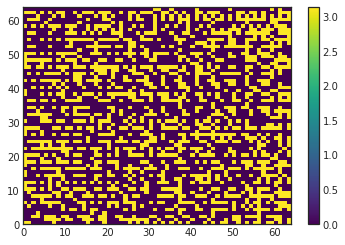

In [118]:
plt.pcolormesh(np.angle(np.squeeze(np.angle(out))))
plt.colorbar()

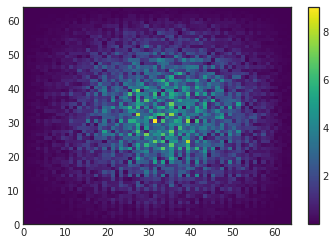

In [119]:
plt.pcolormesh(np.abs(np.squeeze(out)))
plt.colorbar()

In [120]:
print(autoencoder.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 1)]       0         
_________________________________________________________________
complex_conv2d (ComplexConv2 (None, 64, 64, 32)        640       
_________________________________________________________________
complex_conv2d_1 (ComplexCon (None, 32, 32, 32)        18496     
_________________________________________________________________
complex_conv2d_2 (ComplexCon (None, 32, 32, 64)        36992     
_________________________________________________________________
complex_conv2d_3 (ComplexCon (None, 16, 16, 64)        73856     
_________________________________________________________________
complex_conv2d_5 (ComplexCon (None, 8, 8, 128)         147712    
_________________________________________________________________
complex_conv2d_6 (ComplexCon (None, 8, 8, 128)         295168

In [132]:
#cyclic_lr = TriangularCyclicalLearningRate(initial_learning_rate=1e-4,
#                                           maximal_learning_rate=1e-3,
#                                           step_size=478)
optimizer = tf.keras.optimizers.Adam(1e-3)
autoencoder.compile(optimizer=optimizer, loss='mean_absolute_error')

In [133]:
histories = []

In [ ]:
for i in range(5):
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                                  patience=2, min_lr=0.0001, verbose=1)


    checkpoints= tf.keras.callbacks.ModelCheckpoint(wt_path + '/weights' + '.{epoch:02d}.h5',
                                                    monitor='val_loss', verbose=1, save_best_only=True, 
                                                    save_weights_only=False, mode='auto', period=1)




    history = autoencoder.fit(X_train, Y_train, shuffle=True, batch_size=batch_size * 2, verbose=1,
                              epochs=5, validation_split = 0.05, callbacks=[checkpoints, reduce_lr])
    histories.append(history)

Epoch 1/5
239/239 [==============================] - ETA: 0s - loss: 0.0115
Epoch 00001: val_loss improved from inf to 0.01369, saving model to weights_cmplx/weights.01.h5
239/239 [==============================] - 79s 332ms/step - loss: 0.0115 - val_loss: 0.0137 - lr: 5.0000e-04
Epoch 2/5
239/239 [==============================] - ETA: 0s - loss: 0.0109
Epoch 00002: val_loss improved from 0.01369 to 0.01350, saving model to weights_cmplx/weights.02.h5
239/239 [==============================] - 80s 333ms/step - loss: 0.0109 - val_loss: 0.0135 - lr: 5.0000e-04
Epoch 3/5
239/239 [==============================] - ETA: 0s - loss: 0.0107
Epoch 00003: val_loss did not improve from 0.01350
239/239 [==============================] - 79s 331ms/step - loss: 0.0107 - val_loss: 0.0135 - lr: 5.0000e-04
Epoch 4/5
 90/239 [==========>...................] - ETA: 47s - loss: 0.0105

In [135]:
histories

## Plot metrics of the training

In [157]:

for i in range(len(histories)):
    if i == 0:
        epochs = np.array(histories[0].epoch)
        training_losses = np.array(histories[0].history['loss'])
        val_losses =np.array(histories[0].history['val_loss'])
    else:
        epochs = np.concatenate([epochs, epochs[-1] + np.array(histories[i].epoch) + 1], axis=0)
        training_losses = np.concatenate([training_losses,  histories[i].history['loss']], axis=0)
        val_losses =  np.concatenate([val_losses, histories[i].history['val_loss']], axis=0)

In [158]:
epochs

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])

Text(0.5, 0, 'Epochs')

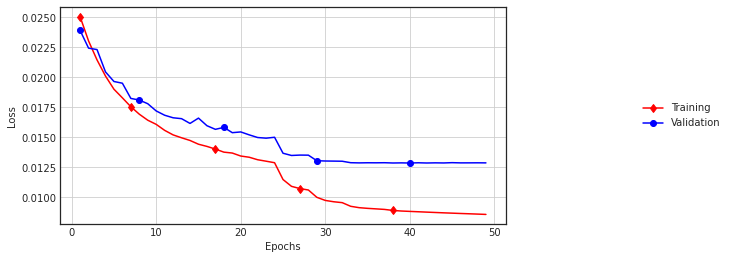

In [159]:
f, axarr = plt.subplots(1, sharex=True, figsize=(8, 4))

axarr.set(ylabel='Loss')
axarr.plot(epochs[1:], training_losses[1:], color='red', marker='d', markevery=0.2, label='Training')
axarr.plot(epochs[1:], val_losses[1:], color='blue', marker='o', markevery=0.2, label='Validation')
axarr.grid()
axarr.legend(loc='center right', bbox_to_anchor=(1.5, 0.5))
plt.xlabel('Epochs')

#axarr[1].set(ylabel='Loss')
#axarr[1].plot(epochs,hist_large.history['conv2d_12_loss'], 'C0o', label='Structure Training')
#axarr[1].plot(epochs,hist_large.history['val_conv2d_12_loss'], 'C0-', label='Structure Validation')
#axarr[1].legend(loc='center right', bbox_to_anchor=(1.5, 0.5))

#plt.tight_layout()
#axarr[1].grid()


#axarr[2].set(ylabel='Loss')
#axarr[2].plot(epochs,hist_large.history['conv2d_19_loss'], 'C0o', label='Phase Training')
#axarr[2].plot(epochs,hist_large.history['val_conv2d_19_loss'], 'C0-', label='Phase Validation')
#axarr[2].legend(loc='center right', bbox_to_anchor=(1.5, 0.5))
#plt.tight_layout()
#axarr[2].grid()

#plt.show()

#print(np.min(hist_large.history['val_conv2d_12_loss']), np.min(hist_large.history['val_conv2d_19_loss']), np.min(hist_large.history['val_loss']))

### Save the epoch with the lowest validation loss
(PtychoNN will use these weights)

In [160]:
min_epoch = np.argmin(val_losses) + 1
print (min_epoch)
#np.save(f'{path}/{wt_path}/min_epoch_large', min_epoch)

41


### Read test data

In [161]:
preds = autoencoder.predict(X_test)

### Load the model from the epoch with lowest validation error

In [162]:
!ls $wt_path

weights.01.h5  weights.02.h5  weights.03.h5  weights.04.h5  weights.05.h5


### Make prediction using the diffraction data alone

In [163]:
preds_intens = np.array([np.abs(preds), np.angle(preds)])

# Plot some instances of the test data, it's FT and the CNN prediction

<Figure size 432x288 with 0 Axes>

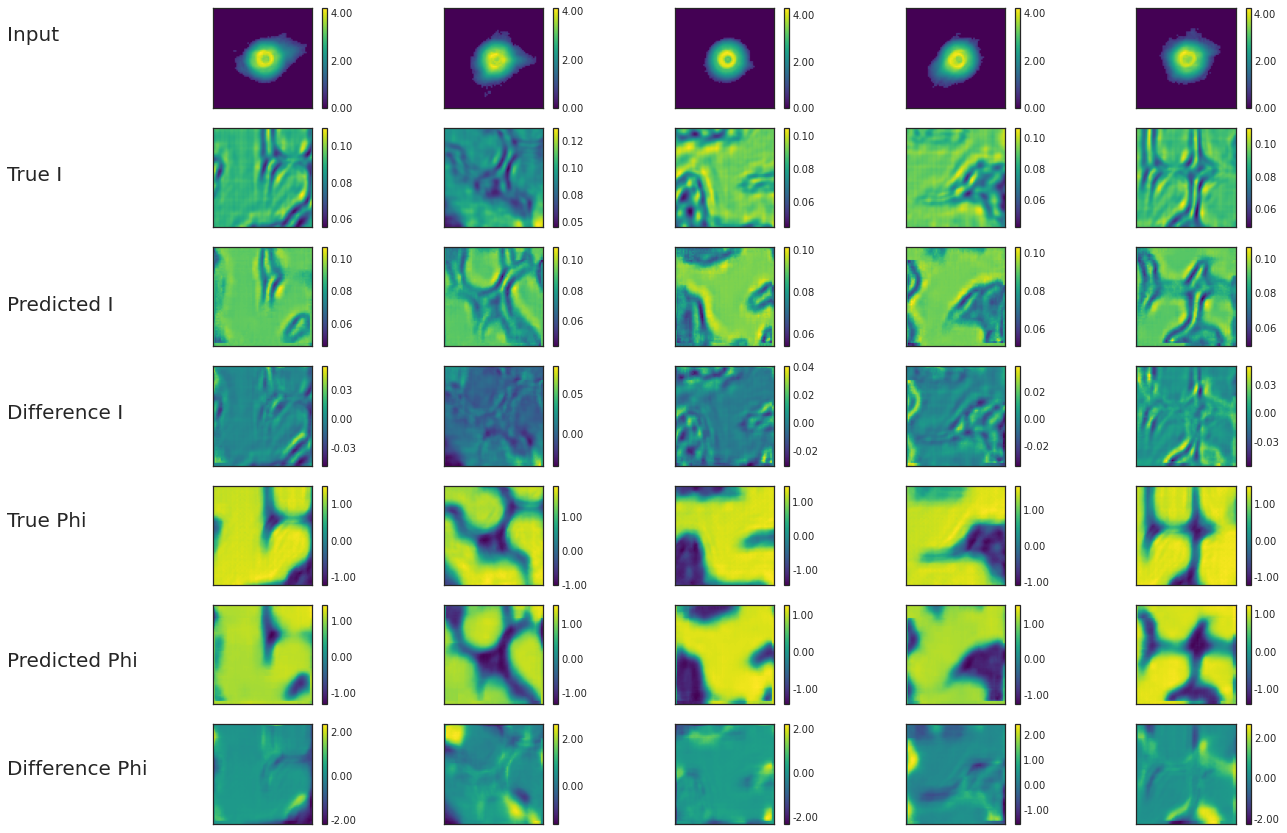

In [164]:
h,w = 64, 64
ntest=preds_intens[0].shape[0]
plt.viridis()
n = 5
f,ax=plt.subplots(7,n,figsize=(20, 15))
plt.gcf().text(0.02, 0.85, "Input", fontsize=20)
plt.gcf().text(0.02, 0.72, "True I", fontsize=20)
plt.gcf().text(0.02, 0.6, "Predicted I", fontsize=20)
plt.gcf().text(0.02, 0.5, "Difference I", fontsize=20)
plt.gcf().text(0.02, 0.4, "True Phi", fontsize=20)
plt.gcf().text(0.02, 0.27, "Predicted Phi", fontsize=20)
plt.gcf().text(0.02, 0.17, "Difference Phi", fontsize=20)

for i in range(0,n):
    j=int(round(np.random.rand()*ntest))

        # display FT
    im=ax[0,i].imshow(np.log10(np.abs(X_test[j]).reshape(h, w)+1))
    plt.colorbar(im, ax=ax[0,i], format='%.2f')
    ax[0,i].get_xaxis().set_visible(False)
    ax[0,i].get_yaxis().set_visible(False)

    # display original intens
    im=ax[1,i].imshow(Y_I_test[j].reshape(h, w))
    plt.colorbar(im, ax=ax[1,i], format='%.2f')
    ax[1,i].get_xaxis().set_visible(False)
    ax[1,i].get_yaxis().set_visible(False)
    
    # display predicted intens
    im=ax[2,i].imshow(preds_intens[0][j].reshape(h, w))
    plt.colorbar(im, ax=ax[2,i], format='%.2f')
    ax[2,i].get_xaxis().set_visible(False)
    ax[2,i].get_yaxis().set_visible(False)
    
        # display original phase
    im=ax[4,i].imshow(Y_phi_test[j].reshape(h, w))
    plt.colorbar(im, ax=ax[4,i], format='%.2f')
    ax[4,i].get_xaxis().set_visible(False)
    ax[4,i].get_yaxis().set_visible(False)
    
    # display predicted phase
    im=ax[5,i].imshow(preds_intens[1][j].reshape(h, w))
    plt.colorbar(im, ax=ax[5,i], format='%.2f')
    ax[5,i].get_xaxis().set_visible(False)
    ax[5,i].get_yaxis().set_visible(False)
    
    #Difference in amplitude
    im=ax[3,i].imshow(Y_I_test[j].reshape(h, w)-preds_intens[0][j].reshape(h, w))
    plt.colorbar(im, ax=ax[3,i], format='%.2f')
    ax[3,i].get_xaxis().set_visible(False)
    ax[3,i].get_yaxis().set_visible(False)
    
    # Difference in phase
    im=ax[6,i].imshow(Y_phi_test[j].reshape(h, w)-preds_intens[1][j].reshape(h, w))
    plt.colorbar(im, ax=ax[6,i], format='%.2f')
    ax[6,i].get_xaxis().set_visible(False)
    ax[6,i].get_yaxis().set_visible(False)
    
plt.show()

In [165]:
point_size = 3
overlap = 4*point_size

In [166]:
tst_side = 60

composite_amp = np.zeros((tst_side*point_size+overlap,tst_side*point_size+overlap),float)
ctr = np.zeros_like(composite_amp)
data_reshaped = preds_intens[0].reshape(tst_side,tst_side,64,64)[:,:,32-int(overlap/2):32+int(overlap/2),
                                                     32-int(overlap/2):32+int(overlap/2)]

for i in range(tst_side):
    for j in range(tst_side):
        composite_amp[point_size*i:point_size*i+overlap, point_size*j:point_size*j+overlap] += data_reshaped[i,j]
        ctr[point_size*i:point_size*i+overlap, point_size*j:point_size*j+overlap] +=1

In [167]:

composite_phase = np.zeros((tst_side*point_size+overlap,tst_side*point_size+overlap),float)
ctr = np.zeros_like(composite_phase)
data_reshaped = preds_intens[1].reshape(tst_side,tst_side,64,64)[:,:,32-int(overlap/2):32+int(overlap/2),
                                                     32-int(overlap/2):32+int(overlap/2)]

for i in range(tst_side):
    for j in range(tst_side):
        composite_phase[point_size*i:point_size*i+overlap, point_size*j:point_size*j+overlap] += data_reshaped[i,j]
        ctr[point_size*i:point_size*i+overlap, point_size*j:point_size*j+overlap] +=1

In [168]:
stitched_phase = composite_phase[int(overlap/2):-int(overlap/2), int(overlap/2):-int(overlap/2)]/ctr[int(overlap/2)
                                                                    :-int(overlap/2), int(overlap/2):-int(overlap/2)]

stitched_amp = composite_amp[int(overlap/2):-int(overlap/2), int(overlap/2):-int(overlap/2)]/ctr[int(overlap/2)
                                                                    :-int(overlap/2), int(overlap/2):-int(overlap/2)]

stitched_amp_down = resize(stitched_amp, (60,60), preserve_range=True, anti_aliasing=True)
stitched_phase_down = resize(stitched_phase, (60,60), preserve_range=True, anti_aliasing=True)

In [169]:
true_amp = Y_I_test.reshape(nltest, nltest, 64,64)
true_ph = Y_phi_test.reshape(nltest, nltest, 64,64)

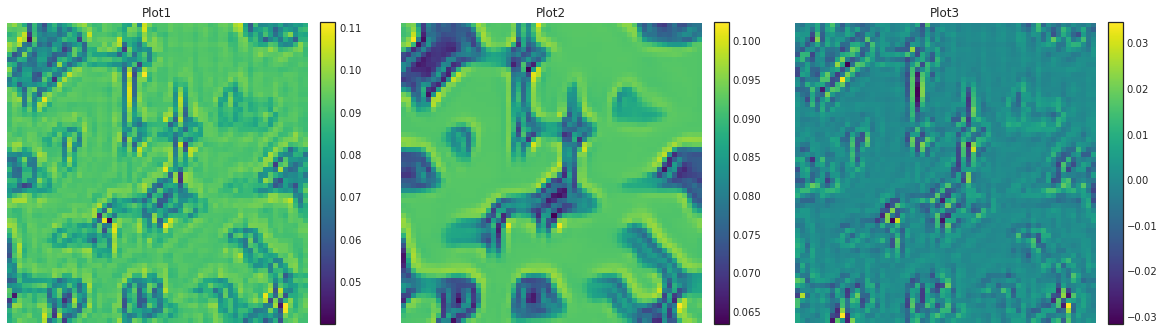

In [170]:
plot3([true_amp[:,:,32,32],stitched_amp_down,stitched_amp_down-true_amp[:,:,32,32]],[])

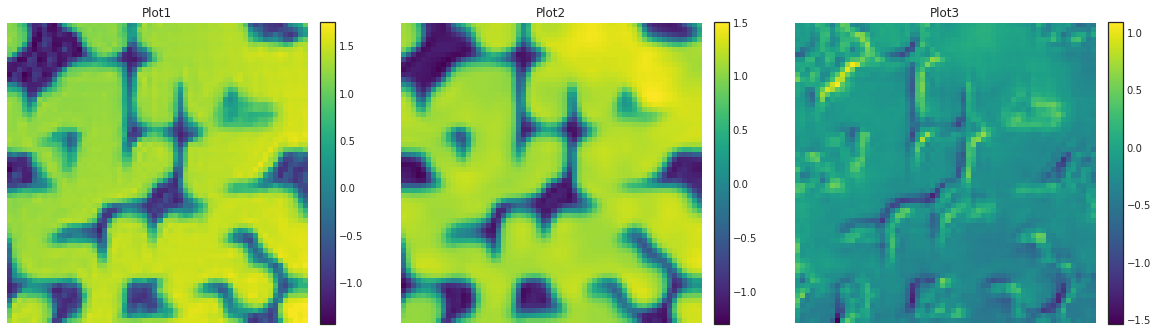

In [171]:
plot3([true_ph[:,:,32,32],stitched_phase_down,stitched_phase_down-true_ph[:,:,32,32]],[])

In [172]:
from sklearn.metrics import mean_squared_error as mse
from skimage.registration import phase_cross_correlation
print ("MSE in amplitude: ", mse(stitched_amp_down, true_amp[:,:,32,32]))
print ("MSE in phase: ", mse(stitched_phase_down, true_ph[:,:,32,32]))

MSE in amplitude:  4.264639774623274e-05
MSE in phase:  0.09261778461794794


In [173]:
true_img = true_amp * np.exp(1j * true_ph)
stitched_img = stitched_amp_down * np.exp(1j * stitched_phase_down)

In [174]:
_roll, _err, _phase = phase_cross_correlation(true_img[:,:,32, 32], stitched_img)
phase_cross_correlation(true_img[:,:,32,32], stitched_img * np.exp(1j * _phase))

(array([0., 0.]), 0.23446909949127917, 1.2210441040599143e-17)

In [307]:
# Attempting a deconvolution

In [338]:
from skimage.restoration import unsupervised_wiener, wiener
from scipy.signal import gaussian

In [355]:
psf = gaussian(20, 2) * gaussian(20, 2)[:,None] / 2

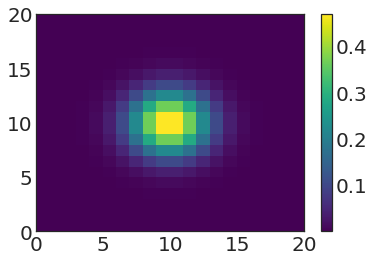

In [356]:
plt.pcolormesh(psf)
plt.colorbar()

In [366]:
deconvolved = unsupervised_wiener(stitched_amp_down, psf)
deconvolved = wiener(stitched_amp_down, psf, 10.0)

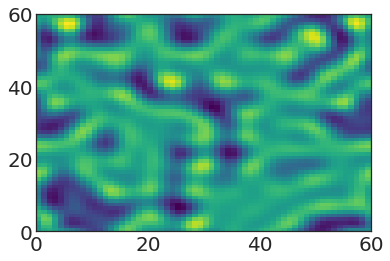

In [367]:
plt.pcolormesh(deconvolved)